# Algorithm Used to solve this project

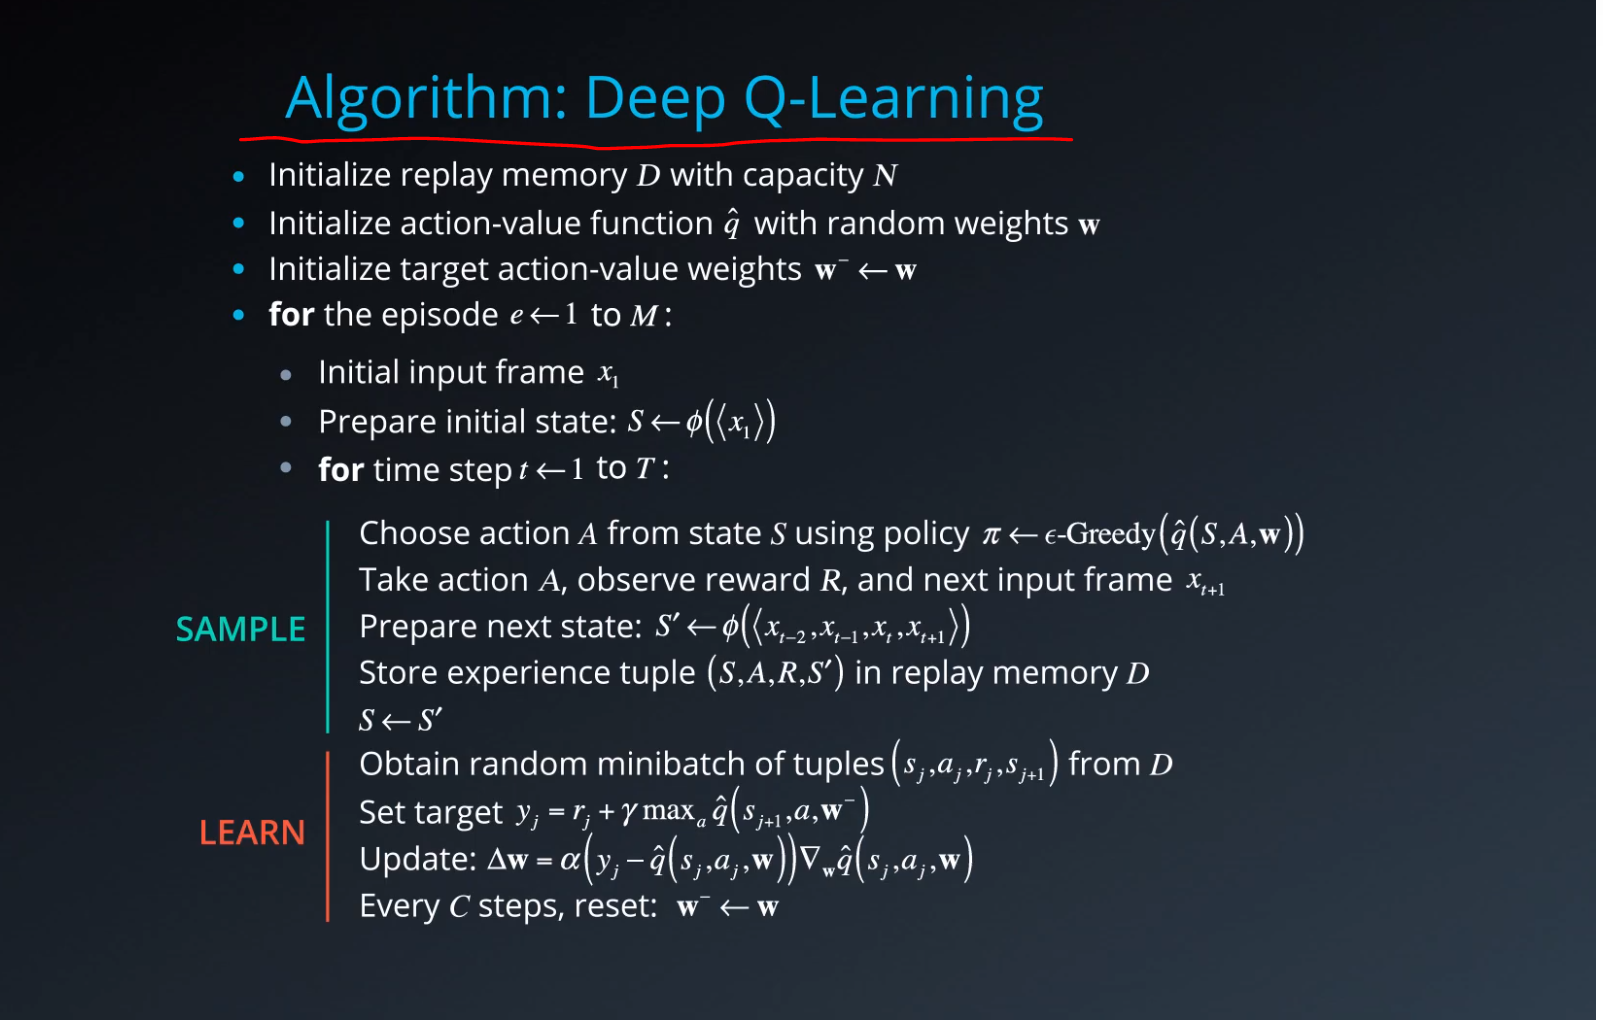

# Import  Library

In [1]:
import matplotlib
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import namedtuple, deque
from unityagents import UnityEnvironment
import numpy as np

# 1. Start the Environment

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


# Get the default brain

In [3]:

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

2. Examine the State and Action Spaces
Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


# 3. Take Random Actions in the Environment


In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that in this coding environment, you will not be able to watch the agent while it is training, and you should set train_mode=True to restart the environment.

In [18]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


In [10]:
env.close()

# 4. It's Your Turn!

# DEFINE Q-NETWORK CLASS

In [5]:
class QNetwork(nn.Module):
    """Actor policy model"""
    def __init__(self,state_size,action_size,seed,fully_connected1_units=1024,fully_connected2_units=64):
        """Initialize parameters and build model
        Params
        ======
        state_size (int): Dimensions of each state
        action_size (int): Dimension of each action
        seed (int) : Random seed
        fully_connected1_units (int): fully connected layer 1
        fully_connected2_units (int): fully connected layer 2
        """
        
        super(QNetwork,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,fully_connected1_units)
        self.fc2 = nn.Linear(fully_connected1_units, fully_connected2_units)
        self.fc3 = nn.Linear(fully_connected2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define Replay Buffer Class

** Replay Buffers are Fixed size Buffer in memory to store state , action taken on that state reward on taking the action, next state presented by env and weather episode ended or not i,e done

To add experiences in the replay buffer we need to define add fuction which will add namedtuple of exp, state,action.reward,next_ **

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            device (torch.device): - (type='cuda', index=0) for GPU 0
                                   - (type='cpu') for CPU
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", 
                                     field_names=["state", "action", "reward", 
                                                  "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

# Define Agent

**An agent interacts with the environment and learns from the environment
initially a state is presented to the agent with what action an agent can take.
to achive that initilize the Agent with state_size and action_size.
Which action agent will take that will be dictated by Qnetwork
After action is taken a reward is presented. That complete episode needs to be stored in memory.
As agent continously learning one function 
**

In [7]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, device):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            device (torch.device): - (type='cuda', index=0) for GPU 0
                                   - (type='cpu') for CPU
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(self.device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed, 
                                   self.device)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        #print(state)
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        Q_targets = rewards + (gamma * self.qnetwork_target(next_states).detach().max(dim=1).values.unsqueeze(1) * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), 
                                             local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [10]:
print("state_size : ", state_size)
print("action size :" ,action_size)
agent = Agent(state_size=state_size, action_size=action_size, seed=0, device=device)

state_size :  37
action size : 4


In [11]:
print( "TARGET NETWORK" , agent.qnetwork_target)
print( "LOCAL NETWORK" , agent.qnetwork_local)


TARGET NETWORK QNetwork(
  (fc1): Linear(in_features=37, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
LOCAL NETWORK QNetwork(
  (fc1): Linear(in_features=37, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


# TRAIN THE AGENT

Episode 100	Average Score: 0.34
Episode 200	Average Score: 3.72
Episode 300	Average Score: 6.97
Episode 400	Average Score: 9.21
Episode 500	Average Score: 11.54
Episode 572	Average Score: 13.00
Environment solved in 472 episodes!	Average Score: 13.00


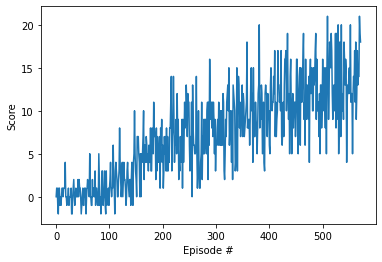

In [12]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action.astype(int))[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            score += reward
            state = next_state
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(
              i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(
                  i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                  i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

saved_model = {'state_size': state_size,
               'action_size': action_size,
               'fully_connected1_units': 1024,
               'fully_connected2_units': 64,
               'state_dict': agent.qnetwork_local.state_dict()}

torch.save(saved_model, 'saved_model.pth2')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


# Load Saved Model

In [15]:
def load_saved_model(filepath, device):
    saved_model = torch.load(filepath)
    qnetwork = QNetwork(state_size=saved_model['state_size'], 
                        action_size=saved_model['action_size'], 
                        seed=0,
                        fully_connected1_units=saved_model['fully_connected1_units'],
                        fully_connected2_units=saved_model['fully_connected2_units']).to(device)
    qnetwork.load_state_dict(saved_model['state_dict'])
    
    return qnetwork

In [16]:
qnetwork = load_saved_model('saved_model.pth2', device)

In [17]:
qnetwork.eval()

QNetwork(
  (fc1): Linear(in_features=37, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [18]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, device=device)
agent.qnetwork_local = qnetwork
agent.qnetwork_target = qnetwork

In [31]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, eps=0.1)             # select an action
    env_info = env.step(action.astype(int))[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 13.0


In [21]:
pip freeze

absl-py==0.11.0Note: you may need to restart the kernel to use updated packages.
argon2-cffi==20.1.0
astor==0.8.1
async-generator==1.10
atomicwrites==1.4.0

attrs==20.3.0
backcall==0.2.0
bleach==1.5.0
certifi==2020.12.5
cffi==1.14.4
colorama==0.4.4
cycler==0.10.0
dataclasses==0.7
decorator==4.4.2
defusedxml==0.6.0
docopt==0.6.2
entrypoints==0.3
gast==0.4.0
grpcio==1.11.0
html5lib==0.9999999
importlib-metadata==3.3.0
iniconfig==1.1.1
ipykernel==5.4.2
ipython==7.16.1
ipython-genutils==0.2.0
ipywidgets==7.6.2
jedi==0.18.0
Jinja2==2.11.2
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.1.7
jupyter-console==6.2.0
jupyter-core==4.7.0
jupyterlab-pygments==0.1.2
jupyterlab-widgets==1.0.0
kiwisolver==1.3.1
Markdown==3.3.3
MarkupSafe==1.1.1
matplotlib==3.3.3
mistune==0.8.4
mkl-fft==1.2.0
mkl-random==1.1.1
mkl-service==2.3.0
nbclient==0.5.1
nbconvert==6.0.7
nbformat==5.0.8
nest-asyncio==1.4.3
notebook==6.1.6
numpy @ file:///C:/ci/numpy_and_numpy_base_1603480701039/work
packaging==20.8
pandocfil